In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


energy = pd.read_csv('../data/raw/energy_dataset.csv')
weather = pd.read_csv('../data/raw/weather_features.csv')

Bu projede tahmin etmek istediğim şey, bir sonraki günün (24 saat sonrası) ortalama elektrik fiyatı. Bunu oluşturmak için, veri setindeki `price actual` sütununu 24 saat ileri kaydırıp ardından 24 saatlik ortalamasını alıyorum.

Bu işlem, modelin bugünkü verilere bakarak yarınki ortalama fiyatı tahmin etmesini sağlıyor. Ayrıca bu yöntem, gelecek veriyi kullanmadan oluşturulduğu için veri sızıntısı (data leakage) riski taşımıyor.

In [2]:
energy = energy.sort_values('time').reset_index(drop=True)
# 1 gün sonrası ortalama fiyat hedefi (sızıntısız)
energy['target_price'] = (
    energy['price actual']
    .shift(-24)
    .rolling(window=24)
    .mean()
)

# Hedefin tanımlanmadığı (son 24 satır) veriler çıkarılır
energy = energy.dropna(subset=['target_price'])

# Tarih formatına çevirme
energy['time'] = pd.to_datetime(energy['time'], utc=True)

In [3]:
energy['weekday'] = energy['time'].dt.weekday
energy['month'] = energy['time'].dt.month
energy['day'] = energy['time'].dt.day
energy['hour'] = energy['time'].dt.hour


energy['hour_sin'] = np.sin(2 * np.pi * energy['hour'] / 24)
energy['hour_cos'] = np.cos(2 * np.pi * energy['hour'] / 24)

energy['month_sin'] = np.sin(2 * np.pi * energy['month'] / 12)
energy['month_cos'] = np.cos(2 * np.pi * energy['month'] / 12)

#sadece gece 00:00 için
energy['is_midnight'] = (energy['hour'] == 0).astype(int)

#hafta sonu bilgisi
energy['is_weekend'] = energy['weekday'].isin([5, 6]).astype(int)
energy['is_weekday'] = (energy['weekday'] < 5).astype(int)

# 1: kış, 2: ilkbahar, 3: yaz, 4: sonbahar
def get_season(month):
    return (month % 12 + 3) // 3
energy['season'] = energy['month'].apply(get_season)

energy['weekofyear'] = energy['time'].dt.isocalendar().week
energy['year'] = energy['time'].dt.year

In [4]:
# 1 Gün Sonrası Tahmini için anlamlı lag listesi
meaningful_lags = [1, 2, 3, 24, 48, 72, 96, 120, 144]

for lag in meaningful_lags:
    energy[f'price_lag_{lag}'] = energy['price actual'].shift(lag)
    energy[f'load_lag_{lag}'] = energy['total load actual'].shift(lag)

Fiyatlarda gün içi veya günler arası genel eğilimleri yakalayabilmek için kaydırmalı ortalama ve standart sapma gibi istatistiksel öznitelikler oluşturdum.

Burada 1, 2 ve 3 günlük pencereler (saat cinsinden 24, 48, 72) kullandım. Bu sayede model, geçmiş birkaç gün içindeki fiyat hareketliliği hakkında fikir sahibi olacak. Ayrıca `shift(1)` ile sadece geçmiş veriye bakılmasını sağladım, böylece sızıntı riski de önlenmiş oldu.

In [5]:
# 1 gün sonrası için anlamlı olabilecek pencere boyutları (1–3 gün)
rolling_windows = [24, 48, 72]  #1, 2 ve 3 gün

for window in rolling_windows:
    energy[f'price_roll_mean_{window}'] = (
        energy['price actual'].shift(1).rolling(window=window).mean()
    )
    energy[f'price_roll_std_{window}'] = (
        energy['price actual'].shift(1).rolling(window=window).std()
    )
    energy[f'load_roll_mean_{window}'] = (
        energy['total load actual'].shift(1).rolling(window=window).mean()
    )
    energy[f'load_roll_std_{window}'] = (
        energy['total load actual'].shift(1).rolling(window=window).std()
    )


Elektrik fiyatları genellikle sağa çarpık bir dağılıma sahiptir. Bu durumu biraz düzeltmek ve modelin daha dengeli öğrenmesini sağlamak için log dönüşümü (`log1p`) uyguladım.

Ayrıca aykırı değerleri belirleyebilmek için 7 günlük (168 saatlik) kaydırmalı pencere ile IQR (interquartile range) hesapladım. Bu yöntemle fiyatın alışılmadık derecede arttığı veya düştüğü noktaları tespit edebiliyorum. Bu tür uc noktalar, modelin tahmin performansını bozabileceği için önemli.

In [6]:
# Log dönüşüm
energy['log_price'] = np.log1p(energy['price actual'])

#outlier belirlemek için 7 günlük (168 saat) rolling IQR kullanımı – geçmişe dayalı
q1 = energy['price actual'].shift(1).rolling(window=168).quantile(0.25)
q3 = energy['price actual'].shift(1).rolling(window=168).quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

#şu anki fiyat, geçmişe göre aykırı mı
energy['is_price_outlier'] = (
    ((energy['price actual'] < lower) | (energy['price actual'] > upper)).astype(int)
)

Bazı desenler zaman serisinde sadece zaman aralığına değil, frekansına da bağlı olabilir. Özellikle periyodik dalgalanmaları yakalayabilmek için fiyat serisinin frekans bileşenlerini (FFT - Fast Fourier Transform) hesapladım.

Bu analizle belirli bir zaman diliminde (örneğin 1 hafta) fiyatların ne kadar düzenli dalgalandığını görebiliyorum. Elde ettiğim öznitelikler; ortalama frekans, maksimum frekans ve standart sapma gibi özetler içeriyor. Bunlar modelin, sezonsal veya tekrar eden davranışları yakalamasına yardımcı olabilir.

In [7]:
def compute_rolling_fft(series, window):
    result = {'fft_mean': [], 'fft_std': [], 'fft_max': []}
    for i in range(len(series)):
        if i< window + 1:  # 1 adım geçmişe kaydırmak için +1
            result['fft_mean'].append(np.nan)
            result['fft_std'].append(np.nan)
            result['fft_max'].append(np.nan)
        else:
            window_data = series.iloc[i - window - 1:i - 1]  # GELECEK VERİ YOK
            fft_vals = np.fft.fft(window_data.fillna(0).values)
            fft_mag = np.abs(fft_vals)
            result['fft_mean'].append(fft_mag.mean())
            result['fft_std'].append(fft_mag.std())
            result['fft_max'].append(fft_mag.max())
    return result



fft_hourly = compute_rolling_fft(energy['price actual'], window=72)

energy['fft_mean'] = fft_hourly['fft_mean']
energy['fft_std'] = fft_hourly['fft_std']
energy['fft_max'] = fft_hourly['fft_max']

In [8]:
fossil_cols = [
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil brown coal/lignite',
    'generation fossil oil',
    'generation fossil oil shale',
    'generation fossil coal-derived gas',
    'generation fossil peat'
]

renewable_cols = [
    'generation hydro water reservoir',
    'generation hydro run-of-river and poundage',
    'generation hydro pumped storage consumption',
    'generation wind onshore',
    'generation wind offshore',
    'generation solar',
    'generation biomass',
    'generation geothermal',
    'generation marine',
    'generation other renewable'
]

other_cols = ['generation nuclear', 'generation waste', 'generation other']


Zaman serilerinde geçmiş değerler genellikle geleceği tahmin etmede işe yarar. Bu yüzden hem fiyat (`price actual`) hem de tüketim (`total load actual`) için geçmişe yönelik çeşitli gecikmeli öznitelikler (lag features) oluşturdum.

Burada kullandığım gecikmeler 1 saatten başlayıp 6 güne kadar (144 saat) uzanıyor. Bu sayede hem kısa vadeli etkileri hem de birkaç gün önceki fiyatların yarattığı etkileri modele tanıtmayı amaçlıyorum.

In [9]:
#üretim verilerini 1 saat gecikmeli alıyoruz sızıntı riskine karşı
for col in fossil_cols + renewable_cols + other_cols:
    energy[f'{col}_lag1'] = energy[col].shift(1)

# Toplam üretim
energy['generation_total'] = energy[[f'{col}_lag1' for col in fossil_cols + renewable_cols + other_cols]].sum(axis=1)

energy['fossil_total'] = energy[[f'{col}_lag1' for col in fossil_cols]].sum(axis=1)
energy['renewable_total'] = energy[[f'{col}_lag1' for col in renewable_cols]].sum(axis=1)

# Oranlar
energy['fossil_ratio'] = energy['fossil_total'] / (energy['generation_total'] + 1e-6)
energy['renewable_ratio'] = energy['renewable_total'] / (energy['generation_total'] + 1e-6)

# Entropi
def entropy(row):
    p = row / (row.sum() + 1e-6)
    return -(p * np.log(p + 1e-6)).sum()

def entropy(row):
    p = row / (row.sum() + 1e-6)
    return -(p * np.log(p + 1e-6)).sum()

entropy_cols = [f'{col}_lag1' for col in fossil_cols + renewable_cols + other_cols]
energy['generation_entropy'] = energy[entropy_cols].apply(entropy, axis=1)

In [10]:
constant_cols = [col for col in energy.columns if energy[col].nunique() <= 1]

numeric_cols = energy.drop(columns=constant_cols, errors='ignore').select_dtypes(include=[np.number])
# Sadece sayısal sütunlar içinden korelasyon analizi
correlations = numeric_cols.corr()
if 'target_price' in correlations.columns:
    target_corr = correlations['target_price'].sort_values(ascending=False)
    print("target_price ile en yüksek korelasyonlu ilk 40 değişken:")
    display(target_corr.head(40))

target_price ile en yüksek korelasyonlu ilk 40 değişken:


target_price                                 1.000000
price_roll_mean_24                           0.867450
price_roll_mean_48                           0.842271
price_roll_mean_72                           0.836635
fft_std                                      0.834841
fft_max                                      0.833541
price actual                                 0.811131
price_lag_1                                  0.803046
log_price                                    0.797094
price_lag_2                                  0.795387
price_lag_3                                  0.788132
price_lag_24                                 0.679159
price_lag_144                                0.663750
price_lag_48                                 0.631157
price_lag_120                                0.625031
price_lag_72                                 0.624813
price_lag_96                                 0.614811
price day ahead                              0.600382
fft_mean                    

In [11]:
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'], utc=True)

In [12]:
madrid_weather = weather[weather['city_name'] == 'Madrid'].copy()
madrid_weather['dt_iso'] = pd.to_datetime(madrid_weather['dt_iso'], utc=True)

#prefix
madrid_weather = madrid_weather.add_prefix('madrid_')
madrid_weather = madrid_weather.rename(columns={'madrid_dt_iso': 'time'})

merged_data= pd.merge(
    energy,
    madrid_weather,
    on='time',
    how='left'
)


In [13]:
print("Yeni shape:", energy.shape)
print("Eklenen weather sütunları:")
print(set(madrid_weather.columns) - {'dt_iso', 'city_name'})

Yeni shape: (35017, 105)
Eklenen weather sütunları:
{'madrid_wind_deg', 'madrid_temp_min', 'madrid_weather_main', 'madrid_temp', 'madrid_weather_icon', 'madrid_pressure', 'madrid_humidity', 'madrid_wind_speed', 'madrid_rain_1h', 'madrid_rain_3h', 'madrid_clouds_all', 'madrid_weather_id', 'madrid_weather_description', 'madrid_city_name', 'madrid_temp_max', 'time', 'madrid_snow_3h'}


In [14]:
#geçmişe göre flagli yağmur kar durumu
merged_data['madrid_is_rainy'] = (merged_data['madrid_rain_3h'].shift(1) > 0).astype(int)
merged_data['madrid_is_snowy'] = (merged_data['madrid_snow_3h'].shift(1) > 0).astype(int)

# 3 saat öncesine göre fark sıcaklık
merged_data['madrid_temp_diff_3h'] = merged_data['madrid_temp'] - merged_data['madrid_temp'].shift(3)

# trend yakalama
merged_data['madrid_temp_roll3_mean'] = merged_data['madrid_temp'].shift(1).rolling(window=3).mean()

# 1 haftalık nem dalgalanması
merged_data['madrid_humidity_roll24_std'] = merged_data['madrid_humidity'].shift(1).rolling(window=24).std()


In [15]:
weather_cols = [
    col for col in merged_data.columns 
    if col.startswith('madrid_') and np.issubdtype(merged_data[col].dtype, np.number)
]

# Korelasyon
corrs = merged_data[weather_cols].corrwith(merged_data['target_price']).abs().sort_values(ascending=False)
display(corrs)

madrid_wind_speed             0.272554
madrid_clouds_all             0.086438
madrid_wind_deg               0.077254
madrid_rain_1h                0.050934
madrid_is_rainy               0.031915
madrid_rain_3h                0.026725
madrid_weather_id             0.025445
madrid_pressure               0.023418
madrid_temp                   0.015032
madrid_temp_roll3_mean        0.015021
madrid_temp_max               0.012240
madrid_snow_3h                0.009673
madrid_is_snowy               0.009631
madrid_temp_min               0.006878
madrid_humidity_roll24_std    0.006059
madrid_temp_diff_3h           0.001237
madrid_humidity               0.000468
dtype: float64

In [16]:
from scipy.fftpack import fft
import numpy as np

def compute_fft_features(series, n_freq=5):
    fft_vals = np.abs(fft(series.fillna(0).values))
    fft_energy = np.sum(fft_vals**2)
    top_freqs = np.sort(fft_vals)[-n_freq:]
    return list(top_freqs) + [fft_energy]


fft_features = []
window_size = 24

#veriyi önceden kaydırıyoruz sızıntıya karşı
shifted_series = merged_data['price actual'].shift(1)

for i in range(window_size, len(merged_data)):
    window = shifted_series.iloc[i - window_size:i]
    window = window.fillna(method="ffill").fillna(method="bfill")  # Eksik verileri doldur
    features = compute_fft_features(window)

    fft_features.append(features)

fft_cols = [f'fft_peak_{i+1}' for i in range(5)] + ['fft_energy']
fft_df = pd.DataFrame(fft_features, columns=fft_cols, index=merged_data.index[window_size:])
merged_data = merged_data.join(fft_df)

In [17]:
def haar_transform(series):
    n = len(series) // 2 * 2  # çift uzunluk
    series = series[:n]
    approx = [(series[i] + series[i+1]) / 2 for i in range(0, n, 2)]
    detail = [(series[i] - series[i+1]) / 2 for i in range(0, n, 2)]
    return np.mean(approx), np.std(approx), np.mean(detail), np.std(detail)

haar_features = []
window_size = 24

#sızıntı riskini önlemek için geçmiş veri ile pencere oluştur
shifted_series = merged_data['price actual'].shift(1)

for i in range(window_size, len(merged_data)):
    window = shifted_series.iloc[i - window_size:i]
    window = window.fillna(method="ffill").fillna(method="bfill")  # Eksikleri doldur

    features = haar_transform(window.values)
    haar_features.append(features)

haar_cols = ['dwt_approx_mean', 'dwt_approx_std', 'dwt_detail_mean', 'dwt_detail_std']
haar_df = pd.DataFrame(haar_features, columns=haar_cols, index=merged_data.index[window_size:])
merged_data = merged_data.join(haar_df)


In [42]:
numeric_features = merged_data.select_dtypes(include=[np.number]).columns.tolist()

print("Sayısal Feature Listesi:")
for i, col in enumerate(numeric_features):
    print(f"{i+1:02d}. {col}")


Sayısal Feature Listesi:
01. generation biomass
02. generation fossil brown coal/lignite
03. generation fossil coal-derived gas
04. generation fossil gas
05. generation fossil hard coal
06. generation fossil oil
07. generation fossil oil shale
08. generation fossil peat
09. generation geothermal
10. generation hydro pumped storage aggregated
11. generation hydro pumped storage consumption
12. generation hydro run-of-river and poundage
13. generation hydro water reservoir
14. generation marine
15. generation nuclear
16. generation other
17. generation other renewable
18. generation solar
19. generation waste
20. generation wind offshore
21. generation wind onshore
22. forecast solar day ahead
23. forecast wind offshore eday ahead
24. forecast wind onshore day ahead
25. total load forecast
26. total load actual
27. price day ahead
28. price actual
29. target_price
30. weekday
31. month
32. day
33. hour
34. hour_sin
35. hour_cos
36. month_sin
37. month_cos
38. is_midnight
39. is_weekend
4

In [44]:
selected_features = [
    'price_lag_24',
    'price_lag_48',
    'load_lag_24',
    'load_lag_48',
    'generation fossil gas_lag1',
    'generation wind onshore_lag1',
    'generation nuclear_lag1',
    'madrid_temp',
    'madrid_humidity',
    'total load actual',
    'price day ahead'
]

target_series = merged_data['target_price']

candidate_windows = [6, 12, 24, 36, 48, 72]
rolling_stats = {'mean': lambda s: s.mean(), 'std': lambda s: s.std()}

# Korelasyon sonuçları
print("Rolling Korelasyon Sonuçları:")
for col in selected_features:
    print(f"\n{col}:")
    for stat_name, stat_func in rolling_stats.items():
        best_corr = (None, 0)
        for w in candidate_windows:
            roll = merged_data[col].shift(1).rolling(window=w).apply(stat_func, raw=True)
            corr = roll.corr(target_series)
            if abs(corr) > abs(best_corr[1]):
                best_corr = (w, corr)
        print(f"  - {stat_name}: en iyi pencere = {best_corr[0]}, korelasyon = {best_corr[1]:.4f}")


Rolling Korelasyon Sonuçları:

price_lag_24:
  - mean: en iyi pencere = 72, korelasyon = 0.7837
  - std: en iyi pencere = 24, korelasyon = 0.1351

price_lag_48:
  - mean: en iyi pencere = 72, korelasyon = 0.7688
  - std: en iyi pencere = 24, korelasyon = 0.1253

load_lag_24:
  - mean: en iyi pencere = 72, korelasyon = 0.0848
  - std: en iyi pencere = 72, korelasyon = 0.1685

load_lag_48:
  - mean: en iyi pencere = 72, korelasyon = 0.0837
  - std: en iyi pencere = 72, korelasyon = 0.1467

generation fossil gas_lag1:
  - mean: en iyi pencere = 24, korelasyon = 0.3399
  - std: en iyi pencere = 24, korelasyon = 0.2451

generation wind onshore_lag1:
  - mean: en iyi pencere = 6, korelasyon = -0.1872
  - std: en iyi pencere = 36, korelasyon = -0.1023

generation nuclear_lag1:
  - mean: en iyi pencere = 72, korelasyon = -0.1101
  - std: en iyi pencere = 72, korelasyon = -0.0080

madrid_temp:
  - mean: en iyi pencere = 72, korelasyon = 0.0230
  - std: en iyi pencere = 24, korelasyon = 0.0951



In [46]:
# Rolling işlemleri için tanım
rolling_features = {
    'price_lag_24': {'mean': 72, 'std': 24},
    'price_lag_48': {'mean': 72, 'std': 24},
    'load_lag_24': {'std': 72},
    'load_lag_48': {'std': 72},
    'generation fossil gas_lag1': {'mean': 24, 'std': 24},
    'generation wind onshore_lag1': {'mean': 6, 'std': 36},
    'generation nuclear_lag1': {'mean': 72},
    'madrid_temp': {'std': 24},
    'total load actual': {'mean': 24, 'std': 72},
    'price day ahead': {'mean': 72}
}

# Rolling feature oluşturma
for feature, stats in rolling_features.items():
    for stat_name, window in stats.items():
        col_name = f"{feature}_roll{window}_{stat_name}"
        merged_data[col_name] = (
            merged_data[feature]
            .shift(1)  # Gelecek bilgi sızıntısını önlemek için
            .rolling(window=window)
            .agg(stat_name)
        )

In [48]:
nan_ratios = merged_data.isna().mean().sort_values(ascending=False)
print("NaN oranı en yüksek 15 kolon:")
display(nan_ratios.head(15))

high_nan_cols = nan_ratios[nan_ratios > 0.3].index.tolist()
print(f"\n{len(high_nan_cols)} kolonun %30'dan fazlası eksik.")


NaN oranı en yüksek 15 kolon:


generation hydro pumped storage aggregated    1.000000
forecast wind offshore eday ahead             1.000000
load_lag_48_roll72_std                        0.039895
load_lag_24_roll72_std                        0.039232
load_roll_std_72                              0.038680
load_roll_mean_72                             0.038680
total load actual_roll72_std                  0.038570
load_roll_mean_48                             0.026091
load_roll_std_48                              0.026091
generation nuclear_lag1_roll72_mean           0.020817
load_roll_std_24                              0.013418
load_roll_mean_24                             0.013418
total load actual_roll24_mean                 0.013390
generation wind onshore_lag1_roll36_std       0.011872
generation fossil gas_lag1_roll24_mean        0.008227
dtype: float64


2 kolonun %30'dan fazlası eksik.


In [50]:
cols_to_drop_nan = [
    'forecast wind offshore eday ahead',
    'generation hydro pumped storage aggregated'
]

In [52]:
constant_cols = [col for col in merged_data.columns if merged_data[col].nunique() <= 1]
print(f"{len(constant_cols)} kolon sabit veya tekil değere sahip.")

15 kolon sabit veya tekil değere sahip.


In [54]:
merged_data.drop(columns=constant_cols, inplace=True)

Modeli eğitirken anlamlı bilgi taşımayan değişkenleri çıkarmak önemli. Bu yüzden önce sabit olan sütunları (tüm satırlarda aynı değere sahip olanlar) tespit edip veri setinden çıkardım.

Sonrasında, kalan sayısal sütunlar arasında korelasyon matrisini hesaplayarak değişkenler arası ilişkileri görselleştirdim. Bu analiz sayesinde birbirine çok benzeyen (yüksek korelasyonlu) sütunlar olup olmadığını da inceleyebiliyorum.

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sayısal kolonlar arasında korelasyon
numeric_cols = merged_data.select_dtypes(include=[np.number]).drop(columns=constant_cols, errors='ignore')
corr_matrix = numeric_cols.corr()

# Yüksek korelasyonlu çiftleri belirle
high_corr_pairs = []
threshold = 0.95

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

print("Yüksek korelasyonlu kolon çiftleri:")
for a, b, c in high_corr_pairs:
    print(f"{a} ve {b} → r = {c:.4f}")


Yüksek korelasyonlu kolon çiftleri:
forecast solar day ahead ve generation solar → r = 0.9931
forecast wind onshore day ahead ve generation wind onshore → r = 0.9943
total load actual ve total load forecast → r = 0.9951
is_weekday ve is_weekend → r = -1.0000
weekofyear ve month → r = 0.9812
price_lag_1 ve price actual → r = 0.9667
load_lag_1 ve total load actual → r = 0.9515
price_lag_2 ve price_lag_1 → r = 0.9666
load_lag_2 ve load_lag_1 → r = 0.9512
price_lag_3 ve price_lag_2 → r = 0.9665
load_lag_3 ve load_lag_2 → r = 0.9511
price_roll_mean_48 ve price_roll_mean_24 → r = 0.9677
price_roll_mean_72 ve price_roll_mean_48 → r = 0.9819
log_price ve price actual → r = 0.9707
fft_std ve price_roll_mean_48 → r = 0.9799
fft_std ve price_roll_mean_72 → r = 0.9995
fft_max ve price_roll_mean_48 → r = 0.9802
fft_max ve price_roll_mean_72 → r = 0.9999
fft_max ve fft_std → r = 0.9996
generation fossil gas_lag1 ve generation fossil gas → r = 0.9697
generation fossil hard coal_lag1 ve generation fos

In [58]:
cols_to_drop_corr = [
    # Forecast yerine gerçek generation verisi tercih edilecek
    'forecast solar day ahead',
    'forecast wind onshore day ahead',
    'total load forecast',

    # İkili redundant ilişkiler
    'is_weekend',  # is_weekday zaten var ve tersi
    'month',       # weekofyear daha ince granülerlik sağlar

    # price actual ile güçlü ilişkili olanlar
    'price actual',
    'log_price',

    # redundant lag'lar (ilk olanlar tutuluyor)
    'price_lag_2', 'price_lag_3',
    'load_lag_2', 'load_lag_3',

    # çok yakın rolling ortalamalar – sadece biri tutulur
    'price_roll_mean_48',
    'price_roll_mean_72',
    
    # fft serileri çok benzer – birkaçı yeterli
    'fft_std', 'fft_max',
    
    # generation verileri – lag1 tercih edilir
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil brown coal/lignite',
    'generation fossil oil',
    'generation hydro run-of-river and poundage',
    'generation wind onshore',
    'generation solar',
    'generation biomass',
    'generation other renewable',
    'generation nuclear',
    'generation waste',
    'generation other',

    # sıcaklık türevleri redundant
    'madrid_temp',
    'madrid_temp_min',
    'madrid_temp_max',
    
    # fft/dwt yoğun tekrar
    'fft_peak_1', 'fft_peak_2', 'fft_peak_3', 'fft_peak_4',
    'price_roll_mean_48',
    'dwt_approx_mean',
    'dwt_approx_std',
]


In [60]:
leaky_cols = [
    "target_price",                    # hedefin kendisi
    "price actual",                   # direkt hedefle ilgili
    "log_price",                      # türevi
    'target_price_roll6_mean'
    "target_price_roll24_mean",       # geleceğe dair bilgi içeriyor
    "target_price_roll24_std",        # aynı şekilde
]

In [62]:
merged_data.drop(columns=cols_to_drop_nan + cols_to_drop_corr, errors='ignore', inplace=True)
X = (
    merged_data
    .drop(columns=leaky_cols, errors='ignore')
    .select_dtypes(include=[np.number])
    .fillna(0)
)
y = merged_data['target_price'].fillna(0)


Veri setinde çok sayıda öznitelik olduğu için, hangi değişkenlerin tahmin açısından daha etkili olduğunu görmek istedim. Bunun için hızlıca bir LightGBM modeli eğitip öznitelik önemlerine baktım.

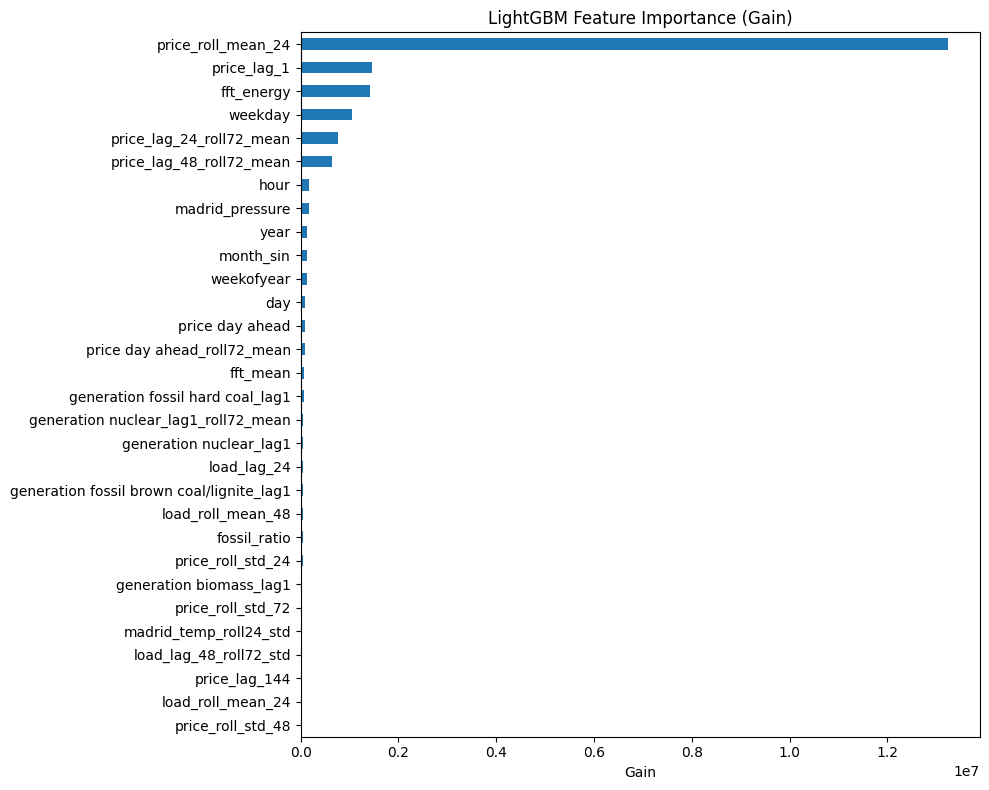

In [64]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = lgb.LGBMRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_bin=255,
    importance_type='gain',
    n_jobs=-1,     
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train)

#önem dereceleri
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances[importances > 0].sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.tail(30).plot(kind='barh')
plt.title("LightGBM Feature Importance (Gain)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()



In [66]:
important_features = importances.sort_values(ascending=False).head(30).index.tolist()

with open("models/important_features.txt", "w") as f:
    for col in important_features:
        f.write(f"{col}\n")

In [68]:
with open("models/important_features.txt", "r") as f:
    selected_features = [line.strip() for line in f if line.strip()]

In [70]:
final_dataset = merged_data[selected_features + ['target_price']].copy()
final_dataset = final_dataset.dropna(axis=1, how='all')

#eğitim setinden mean alınarak doldurarak sızıntı engellenir
n_total = len(final_dataset)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)

df_train = final_dataset.iloc[:n_train].copy()
df_val   = final_dataset.iloc[n_train:n_train + n_val].copy()
df_test  = final_dataset.iloc[n_train + n_val:].copy()

#sadece feature kolonlarını kullanarak ortalama ile doldur
feature_cols = selected_features

fill_values = df_train[feature_cols].mean()

df_train[feature_cols] = df_train[feature_cols].fillna(fill_values)
df_val[feature_cols]   = df_val[feature_cols].fillna(fill_values)
df_test[feature_cols]  = df_test[feature_cols].fillna(fill_values)

# Eksiklik kontrolü
print("NaN kontrolü:")
print("Train:", df_train[feature_cols].isnull().sum().sum())
print("Val:  ", df_val[feature_cols].isnull().sum().sum())
print("Test: ", df_test[feature_cols].isnull().sum().sum())


NaN kontrolü:
Train: 0
Val:   0
Test:  0


In [72]:
# time sütunu dahil edilerek günlük veri kaydedilir
final_dataset['time'] = merged_data['time']
final_dataset.to_csv("../data/processed/final_daily_dataset.csv", index=False)

In [78]:
import pandas as pd
import numpy as np

daily_df = pd.read_csv("../data/processed/final_daily_dataset.csv", parse_dates=["time"])
daily_df= daily_df.sort_values("time").reset_index(drop=True)

print("<Daily veri yüklendi.")
print(f"Toplam satır: {len(daily_df)}")
print(f"Zaman aralığı: {daily_df['time'].min()} → {daily_df['time'].max()}")


<Daily veri yüklendi.
Toplam satır: 36220
Zaman aralığı: 2015-01-01 22:00:00+00:00 → 2018-12-30 22:00:00+00:00


In [80]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(daily_df)
n_train = int(n * train_ratio)
n_val = int(n * val_ratio)

df_train = daily_df.iloc[:n_train].copy()
df_val   = daily_df.iloc[n_train:n_train + n_val].copy()
df_test  = daily_df.iloc[n_train + n_val:].copy()


In [82]:
#target ve feature listeleri
target_col = "target_price"
feature_cols = list(daily_df.drop(columns=["target_price", "time"]).columns)

X_train = df_train[feature_cols].copy()
X_val   = df_val[feature_cols].copy()
X_test  = df_test[feature_cols].copy()

y_train = df_train[target_col].copy()
y_val   = df_val[target_col].copy()
y_test  = df_test[target_col].copy()

#eksik doldurma
fill_values = X_train.mean()
X_train = X_train.fillna(fill_values)
X_val   = X_val.fillna(fill_values)
X_test  = X_test.fillna(fill_values)

numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = list(set(feature_cols) - set(numeric_cols))

X_train = X_train.drop(columns=categorical_cols)
X_val   = X_val.drop(columns=categorical_cols)
X_test  = X_test.drop(columns=categorical_cols)

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [86]:
print("NaN kontrolü:")
print(f"X_train_scaled NaN var mı? {np.isnan(X_train_scaled).any()}")
print(f"X_val_scaled   NaN var mı? {np.isnan(X_val_scaled).any()}")
print(f"X_test_scaled  NaN var mı? {np.isnan(X_test_scaled).any()}")


NaN kontrolü:
X_train_scaled NaN var mı? False
X_val_scaled   NaN var mı? False
X_test_scaled  NaN var mı? False


In [88]:
print("Eksik kalan sütunlar (train):")
print(X_train.columns[X_train.isnull().any()])

Eksik kalan sütunlar (train):
Index([], dtype='object')


In [90]:
(X_train.isnull().mean() * 100).sort_values(ascending=False).head(100)


price_roll_mean_24                           0.0
price_lag_1                                  0.0
fft_energy                                   0.0
weekday                                      0.0
price_lag_24_roll72_mean                     0.0
price_lag_48_roll72_mean                     0.0
hour                                         0.0
madrid_pressure                              0.0
year                                         0.0
month_sin                                    0.0
weekofyear                                   0.0
day                                          0.0
price day ahead                              0.0
price day ahead_roll72_mean                  0.0
fft_mean                                     0.0
generation fossil hard coal_lag1             0.0
generation nuclear_lag1_roll72_mean          0.0
generation nuclear_lag1                      0.0
load_lag_24                                  0.0
generation fossil brown coal/lignite_lag1    0.0
load_roll_mean_48   

In [92]:
import joblib
import os

model_dir = "models_daily"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(X_train_scaled, os.path.join(model_dir, "X_train_scaled.pkl"))
joblib.dump(X_val_scaled,   os.path.join(model_dir, "X_val_scaled.pkl"))
joblib.dump(X_test_scaled,  os.path.join(model_dir, "X_test_scaled.pkl"))

joblib.dump(X_train, os.path.join(model_dir, "X_train.pkl"))
joblib.dump(X_val,   os.path.join(model_dir, "X_val.pkl"))
joblib.dump(X_test,  os.path.join(model_dir, "X_test.pkl"))

joblib.dump(y_train, os.path.join(model_dir, "y_train.pkl"))
joblib.dump(y_val,   os.path.join(model_dir, "y_val.pkl"))
joblib.dump(y_test,  os.path.join(model_dir, "y_test.pkl"))

joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

print("Tüm günlük veriler 'models_daily/' klasörüne başarıyla kaydedildi.")


Tüm günlük veriler 'models_daily/' klasörüne başarıyla kaydedildi.


Bu bölümde, elektrik fiyatı zaman serisi verisini kullanarak bir sonraki günün ortalama fiyatını tahmin edebilmek için öznitelik mühendisliği yaptım. Önce hedef değişkeni dikkatlice tanımladım ve sızıntı olmaması için ileri kaydırma ile günlük ortalamayı oluşturdum.

Daha sonra zaman, lag, rolling, üretim ve frekans tabanlı birçok öznitelik oluşturdum. Ayrıca aykırı değerleri analiz ettim ve gereksiz/sabit sütunları veri setinden çıkardım. LightGBM ile yaptığım ön analiz sayesinde, hangi özniteliklerin model açısından daha önemli olduğunu da belirlemiş oldum.

Bu işlemler sonucunda, hem kapsamlı hem de anlamlı bir öznitelik seti oluşturuldu. 